Skipping 0.0025B_abs due to low R² value: 0.7876
Skipping 0.0025G_abs due to low R² value: 0.5386
Skipping 0.005G_abs due to low R² value: 0.6071
Skipping 0.05G_abs due to low R² value: 0.8827
Skipping 0.0025R_abs due to low R² value: 0.7074

Optimal Regression Analysis Summary (No Intercept: y = kx, R² > 0.9):

Blue Channel:
Conc.   Points   Max Path   Slope (k)    R-squared 
----------------------------------------------------
0.005   164      14.970     0.0146       0.9494    
0.01    148      13.994     0.0263       0.9805    
0.015   164      14.970     0.0408       0.9890    
0.02    164      14.970     0.0533       0.9975    
0.025   132      13.018     0.0561       0.9982    
0.03    132      13.018     0.0709       0.9977    
0.035   100      11.067     0.0717       0.9971    
0.045   84       10.091     0.0761       0.9964    
0.05    32       6.921      0.1176       0.9691    

Green Channel:
Conc.   Points   Max Path   Slope (k)    R-squared 
-------------------------------

C:\Users\kaan\AppData\Local\Temp\ipykernel_7836\1716243346.py:363: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


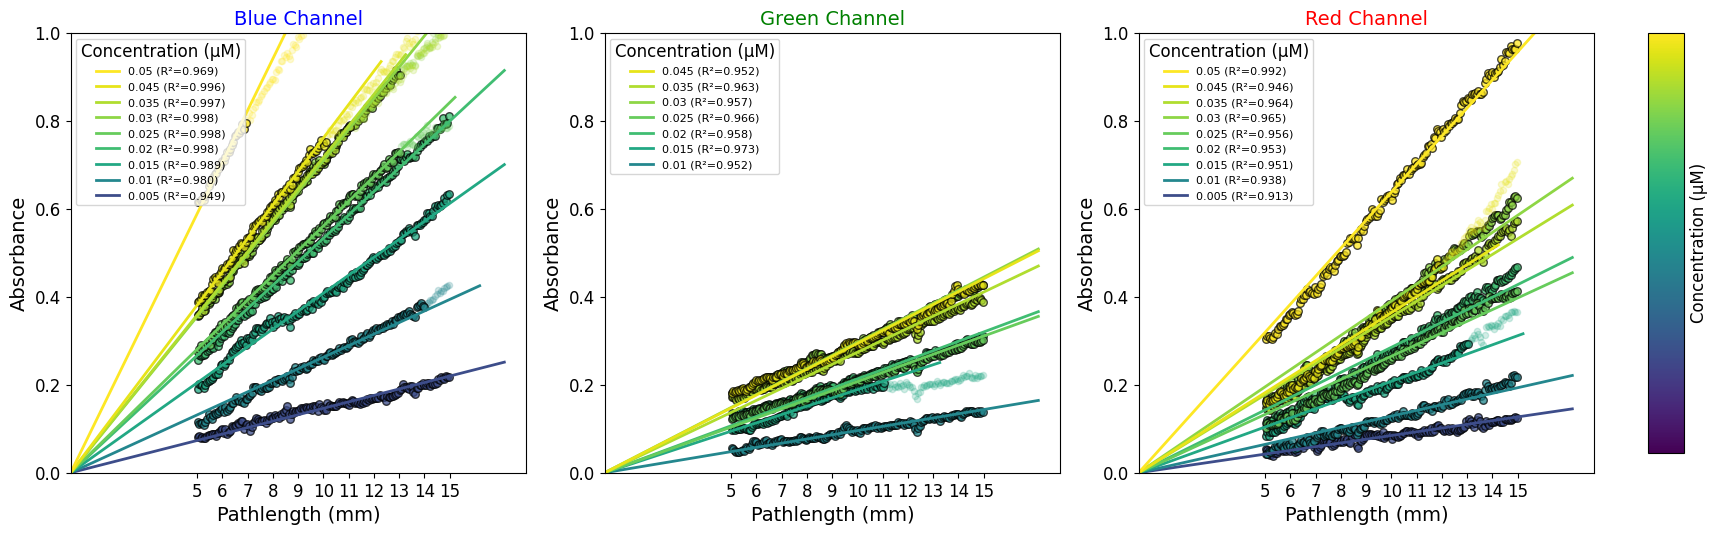

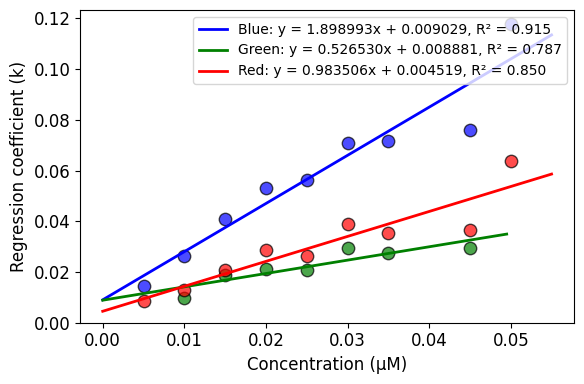

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator, NullLocator

def regression_without_intercept(x, y, force_positive_slope=True):
    """
    Perform linear regression without intercept (y = kx) and calculate R²
    based on the mean of y.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates (pathlength)
    y : array-like
        y-coordinates (absorbance)
    force_positive_slope : bool
        If True, ensure the slope k is always positive
        
    Returns:
    --------
    dict containing regression results
    """
    x = np.array(x)
    y = np.array(y)
    
    # Ensure data is sorted by x (from small to large)
    sort_indices = np.argsort(x)
    x = x[sort_indices]
    y = y[sort_indices]
    
    # Linear regression through the origin (no intercept)
    # Using the formula: k = sum(x*y) / sum(x²)
    numerator = np.sum(x * y)
    denominator = np.sum(x**2)
    
    if denominator != 0:
        slope = numerator / denominator
    else:
        slope = 0
        
    # Force positive slope if requested
    if force_positive_slope and slope <= 0:
        # If regression gives negative/zero slope, use optimization with constraint
        def sum_squared_residuals(params):
            k = params[0]
            y_pred = k * x
            return np.sum((y - y_pred) ** 2)
        
        # Initial parameter (small positive slope)
        initial_params = [0.0001]
        
        # Constraints: ensure k > 0
        constraints = [{'type': 'ineq', 'fun': lambda params: params[0]}]  # k > 0
        
        # Perform optimization
        result = optimize.minimize(sum_squared_residuals, initial_params, 
                                  constraints=constraints, 
                                  method='SLSQP')
        
        # Extract optimized parameter
        slope = result.x[0]
    
    # Predicted values
    y_pred = slope * x
    
    # Residuals
    residuals = y - y_pred
    
    # Calculate R² based on the mean of y
    # R² = 1 - SS_res / SS_tot, where:
    # SS_res = sum((y - y_pred)²)
    # SS_tot = sum((y - mean(y))²)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    
    if ss_tot != 0:
        r_squared = 1 - (ss_res / ss_tot)
    else:
        r_squared = 0  # Avoid division by zero
    
    return {
        "slope": slope,
        "intercept": 0,  # Always zero for regression through origin
        "r_squared": r_squared,
        "residuals": residuals,
        "is_good_fit": r_squared > r2_limit  # Changed threshold to 0.9
    }

def decreasing_subset_regression_no_intercept(x, y, step_size=3, min_points=32, force_positive_slope=True):
    """
    Perform linear regression without intercept (y = kx) with gradually decreasing data size
    to find the subset with the best R² value, calculated based on the mean of y.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates (pathlength)
    y : array-like
        y-coordinates (absorbance)
    step_size : int
        Number of data points to decrease at each step
    min_points : int
        Minimum number of data points to consider for regression
    force_positive_slope : bool
        If True, ensure the slope k is always positive
        
    Returns:
    --------
    dict containing results of the analysis with the best R² value
    """
    x = np.array(x)
    y = np.array(y)
    
    # Ensure data is sorted by x (from small to large)
    sort_indices = np.argsort(x)
    x = x[sort_indices]
    y = y[sort_indices]
    
    # Check if there's enough data for the analysis
    if len(x) < min_points:
        raise ValueError(f"Not enough data points. Need at least {min_points}, but got {len(x)}")
    
    # Track regression results for different ranges
    results_by_size = []
    
    # Calculate indices to evaluate (decreasing by step_size)
    # Start from full dataset, then decrease by step_size
    indices_to_check = list(range(len(x), min_points - 1, -step_size))
    
    # Make sure we include the smallest valid subset size
    if indices_to_check[-1] > min_points:
        indices_to_check.append(min_points)
    
    # Analyze each subset
    for i in indices_to_check:
        x_subset = x[:i]
        y_subset = y[:i]
        
        # Perform regression without intercept
        reg_result = regression_without_intercept(x_subset, y_subset, force_positive_slope)
        
        # Store results for this subset
        subset_result = {
            "subset_size": i,
            "max_x": x_subset[-1],
            "slope": reg_result["slope"],
            "r_squared": reg_result["r_squared"],
            "residuals": reg_result["residuals"],
            "x_subset": x_subset,
            "y_subset": y_subset,
            "y_pred": reg_result["slope"] * x_subset
        }
        
        results_by_size.append(subset_result)
    
    # Find the subset with the best R² value
    best_result = max(results_by_size, key=lambda x: x["r_squared"])
    
    # Add all results to the best result for reference
    best_result["all_results"] = results_by_size
    
    return best_result

def analyze_multi_channel_data_optimal_no_intercept(df, concentrations, channels, step_size=3, min_points=10, force_positive_slope=True):
    """
    Analyze data for multiple concentrations and channels to find optimal regression
    without intercept (y = kx) by decreasing data size until finding the best R² value.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing 'pathlength' and absorbance columns
    concentrations : list
        List of concentration values
    channels : list
        List of channel identifiers (e.g., 'B', 'G', 'R')
    step_size : int
        Number of data points to decrease at each step
    min_points : int
        Minimum number of data points to consider for regression
    force_positive_slope : bool
        If True, ensure the slope k is always positive
        
    Returns:
    --------
    dict containing optimal regression results for all concentrations and channels
    """
    results = {}
    
    for channel in channels:
        channel_results = {}
        for conc in concentrations:
            column_name = f"{conc}{channel}_abs"
            if column_name in df.columns:
                x = df['pathlength'].values
                y = df[column_name].values
                
                # Apply decreasing subset regression without intercept
                try:
                    reg_results = decreasing_subset_regression_no_intercept(
                        x, y, 
                        step_size=step_size, 
                        min_points=min_points,
                        force_positive_slope=force_positive_slope
                    )
                    # Only store results if R² > 0.9
                    if reg_results["r_squared"] > r2_limit:
                        channel_results[conc] = reg_results
                    else:
                        print(f"Skipping {column_name} due to low R² value: {reg_results['r_squared']:.4f}")
                except Exception as e:
                    print(f"Error analyzing {column_name}: {e}")
            else:
                print(f"Warning: Column {column_name} not found in the dataframe")
                
        results[channel] = channel_results
        
    return results



def plot_optimal_regression_results_no_intercept(df, results, concentrations, channels):
    """
    Plot the optimal regression results without intercept (y = kx) 
    for multiple channels and concentrations, only showing results with R² > 0.9
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the original data
    results : dict
        Results from analyze_multi_channel_data_optimal_no_intercept function
    concentrations : list
        List of concentration values
    channels : list
        List of channel identifiers (e.g., 'B', 'G', 'R')
    """
    # Create color map for concentrations
    color_norm = LogNorm(vmin=min(concentrations), vmax=max(concentrations))
    color_map = plt.cm.viridis
    
    # Create figure with three subplots (one for each channel)
    fig, axes = plt.subplots(1, len(channels), figsize=(18, 6))
    
    plt.rcParams.update({'font.size': 12})
    
    # Dictionary to map channel letters to full names
    channel_names = {'B': 'Blue', 'G': 'Green', 'R': 'Red'}
    channel_colors = {'B': 'blue', 'G': 'green', 'R': 'red'}
    
    # Loop through each channel
    for idx, channel in enumerate(channels):
        ax = axes[idx]
        channel_results = results[channel]
        
        # Set subplot title
        channel_name = channel_names.get(channel, channel)
        color = channel_colors.get(channel, 'black')
        ax.set_title(f'{channel_name} Channel', fontsize=14, color=color)
        
        # Prepare for legend entries
        legend_entries = []
        
        # Loop through each concentration that has results with R² > 0.9
        # Sort concentrations to ensure they are plotted from low to high
        for conc in sorted(channel_results.keys()):
            # Get regression results for this concentration
            reg_result = channel_results[conc]
            
            # Get the data
            column_name = f"{conc}{channel}_abs"
            if column_name in df.columns:
                # Get full dataset
                x = df['pathlength'].values
                y = df[column_name].values
                
                # Sort data by x
                sort_idx = np.argsort(x)
                x = x[sort_idx]
                y = y[sort_idx]
                
                # Plot all data points (transparent)
                color = color_map(color_norm(conc))
                ax.scatter(x, y, color=color, alpha=0.2, s=20)
                
                # Plot the optimal subset (more opaque)
                x_subset = reg_result['x_subset']
                y_subset = reg_result['y_subset']
                ax.scatter(x_subset, y_subset, color=color, alpha=0.7, s=30, edgecolor='black')
                
                # Plot optimal regression line through origin
                # Instead of extending to max(x), limit to cutoff + 36 data points
                cutoff_x = reg_result['max_x']
                # Calculate extension length (36 data points after cutoff)
                # Estimate the x-spacing based on the data
                if len(x) > 1:
                    avg_spacing = np.median(np.diff(np.sort(x)))
                    extension_length = 36 * avg_spacing
                else:
                    extension_length = (max(x) - cutoff_x) * 0.2  # Fallback if only one point
                
                # Create x points for regression line from 0 to cutoff + extension
                x_fit = np.linspace(0, cutoff_x + extension_length, 100)
                y_fit = reg_result['slope'] * x_fit
                line, = ax.plot(x_fit, y_fit, '-', color=color, linewidth=2)
                
                # Removed the vertical line showing the cutoff point
                
                # Create legend entry - removed 'n' value as requested
                legend_entry = f"{conc} (R²={reg_result['r_squared']:.3f})"
                legend_entries.append((line, legend_entry))
        
        # Check if there are any results to show
        if not legend_entries:
            ax.text(0.5, 0.5, 'No results with R² > 0.8', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=12, color='red')
        else:
            # Sort legend entries by concentration (low to high from bottom to top)
            # We need to extract the concentration from the legend entry, which is the first part before the space
            legend_entries.sort(key=lambda x: float(x[1].split()[0]), reverse=True)
            lines, labels = zip(*legend_entries)
            
            # Create custom legend
            ax.legend(lines, labels, title="Concentration (μM)", fontsize=8, 
                     loc='upper left')
        
        # Set labels
        ax.set_xlabel('Pathlength (mm)', fontsize=14)
        ax.set_ylabel('Absorbance', fontsize=14)
        # ax.grid(True, alpha=0.3)
        
        # Ensure the plot includes the origin (0,0)
        ax.set_xlim(left=0)
        x_ticks = list(range(5, 16))  # Creates [5, 6, 7, ..., 15]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([str(i) for i in x_ticks])
        ax.set_ylim(0, 1.0)
    
    # Add colorbar if there are any results
    any_results = any(len(results[ch]) > 0 for ch in channels)
    if any_results:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    
        # Add a colorbar with logarithmically spaced ticks
        sm = plt.cm.ScalarMappable(cmap=color_map, norm=color_norm)
        sm.set_array([])
        # Create logarithmically spaced ticks
        tick_locations = [1, 5, 10, 50, 100, 500, 1000, 5000]
        cbar = fig.colorbar(sm, cax=cbar_ax, ticks=tick_locations)
        cbar.set_ticklabels([str(tick) for tick in tick_locations])

        cbar.ax.yaxis.set_major_locator(FixedLocator(tick_locations))  
        cbar.ax.yaxis.set_minor_locator(NullLocator())               
        cbar.ax.tick_params(which='both', width=0, length=0)        
        cbar.set_label('Concentration (µM)')
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.subplots_adjust(top=0.85)
    
    return fig

def plot_concentration_vs_slope(results, channels, concentrations):
    """
    Plot concentration versus slope with linear regression lines for each channel
    
    Parameters:
    -----------
    results : dict
        Results from analyze_multi_channel_data_optimal_no_intercept function
    channels : list
        List of channel identifiers (e.g., 'B', 'G', 'R')
    concentrations : list
        List of concentration values
        
    Returns:
    --------
    matplotlib figure object
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Dictionary to map channel letters to colors and names
    channel_colors = {'B': 'blue', 'G': 'green', 'R': 'red'}
    channel_names = {'B': 'Blue', 'G': 'Green', 'R': 'Red'}
    
    # Legend entries
    legend_entries = []

    
    # Loop through each channel
    for channel in channels:
        channel_results = results[channel]
        
        # Skip if there are no results for this channel
        if len(channel_results) == 0:
            continue
            
        # Extract concentrations and slopes
        concs = np.array(sorted(channel_results.keys()))
        slopes = np.array([channel_results[conc]['slope'] for conc in concs])
        
        # Skip if there are fewer than 2 data points
        if len(concs) < 2:
            continue
        
        # Plot concentration vs slope
        color = channel_colors.get(channel, 'black')
        channel_name = channel_names.get(channel, channel)
        
        # Plot the data points
        scatter = ax.scatter(concs, slopes, color=color, s=80, alpha=0.7, 
                           label=f"{channel_name} Channel", edgecolor='black')
        
        # Perform linear regression (y = mx + b)
        slope, intercept, r_value, p_value, std_err = stats.linregress(concs, slopes)
        
        # Generate points for the regression line
        x_fit = np.linspace(0, max(concs) * 1.1, 100)
        y_fit = slope * x_fit + intercept
        
        # Plot the regression line
        line, = ax.plot(x_fit, y_fit, '-', color=color, linewidth=2)
        
        # Format the slope to avoid scientific notation
        slope_str = f"{slope:.6f}"
        
        # Format the intercept with only + or - sign
        if intercept >= 0:
            intercept_str = f"+ {abs(intercept):.6f}"
        else:
            intercept_str = f"- {abs(intercept):.6f}"
        
        # Create label for the regression line
        reg_label = f"{channel_name}: y = {slope_str}x {intercept_str}, R² = {r_value**2:.3f}"
        legend_entries.append((line, reg_label))
    
    # Check if there are any results to show
    if not legend_entries:
        ax.text(0.5, 0.5, 'No channels have enough data points with R² > 0.9', 
               horizontalalignment='center', verticalalignment='center',
               transform=ax.transAxes, fontsize=12, color='red')
    else:
        # Create custom legend
        lines, labels = zip(*legend_entries)
        ax.legend(lines, labels, fontsize=10, loc='upper right')
    
    # Set labels
    ax.set_xlabel('Concentration (μM)', fontsize=12)
    ax.set_ylabel('Regression coefficient (k)', fontsize=12)
    # ax.grid(True, alpha=0.3)
    
    # Force y-axis to start at 0
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    return fig


def analyze_and_plot_optimal_no_intercept(df, concentrations, channels, step_size=3, min_points=10, force_positive_slope=True):
    """
    Analyze and plot optimal regression results without intercept (y = kx) by decreasing data size,
    only showing results with R² > 0.9
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing 'pathlength' and absorbance columns
    concentrations : list
        List of concentration values
    channels : list
        List of channel identifiers (e.g., 'B', 'G', 'R')
    step_size : int
        Number of data points to decrease at each step
    min_points : int
        Minimum number of data points to consider for regression
    force_positive_slope : bool
        If True, ensure the slope k is always positive
        
    Returns:
    --------
    tuple (results, fig1, fig2) containing regression results and plot figures
    """
    # Analyze data
    results = analyze_multi_channel_data_optimal_no_intercept(
        df, concentrations, channels, 
        step_size=step_size, 
        min_points=min_points,
        force_positive_slope=force_positive_slope
    )
    
    # Print summary of results
    print("\nOptimal Regression Analysis Summary (No Intercept: y = kx, R² > 0.9):")
    
    # Check if there are any results to show
    any_results = any(len(results[ch]) > 0 for ch in channels)
    
    if not any_results:
        print("No concentrations achieved R² > 0.9 in any channel.")
    else:
        for channel in channels:
            channel_name = {'B': 'Blue', 'G': 'Green', 'R': 'Red'}.get(channel, channel)
            
            if len(results[channel]) == 0:
                print(f"\n{channel_name} Channel: No concentrations achieved R² > 0.9")
                continue
                
            print(f"\n{channel_name} Channel:")
            print(f"{'Conc.':<7} {'Points':<8} {'Max Path':<10} {'Slope (k)':<12} {'R-squared':<10}")
            print("-" * 52)
            
            channel_results = results[channel]
            for conc in sorted(channel_results.keys()):
                reg = channel_results[conc]
                print(f"{conc:<7} {reg['subset_size']:<8} {reg['max_x']:<10.3f} {reg['slope']:<12.4f} {reg['r_squared']:<10.4f}")
    
    # Plot regression results
    fig1 = plot_optimal_regression_results_no_intercept(df, results, concentrations, channels)
    
    # Plot concentration vs slope
    fig2 = plot_concentration_vs_slope(results, channels, concentrations)
    
    return results, fig1, fig2

if __name__ == "__main__":
    # Load data
    df = pd.read_csv('DNG_pi_data.csv')
    
    r2_limit = 0.90  # Set R² threshold for filtering
    
    # Define concentrations and channels
    concentrations = [0.0025, 0.005, 0.01, 0.015,
                      0.02, 0.025, 0.03, 0.035, 0.045, 0.05]

    channels = ['B', 'G', 'R']
    
    # Analyze and plot data
    results, fig1, fig2 = analyze_and_plot_optimal_no_intercept(
        df, 
        concentrations, 
        channels, 
        step_size=16,  # Decrease by 16 points at each step
        min_points=32,  # Minimum 32 points for regression
        force_positive_slope=True
    )
    
    plt.show()